# Pre-processing of the COCO datasets from Label Studio

First we download the dataset from Kaggle in this link https://www.kaggle.com/datasets/ryandpark/fruit-quality-classification?fbclid=IwAR01WrwBFqeVrAb5f8enTjl5Xn4DFAx3XscyW2PVaM-h15MHCayPaurnnkA and we will process only the file called Mixed Fruit. After that we use Label-Studio in order to do the annotation we want. In our project we used only the pictures which contained 5 elements(fruits) of Banana and Lemon and 4 element(fruits) of Orange and Pomegranate. So, we kept images with 5 fruits for dataset of Lemon and Banana, and with 4 fruits for Orange and Pomagranate.

We choose to keep only a specific amount of elements in all images and in only 2 of the 6 fruits, because our model was trained better and was producing better results. When we used more than two fruits the model was not performing good

After that we load those datasets we kept with the specific number of fruits and the combinations we wanted in Label-Studio. Then we do the labeling and extract the datasets in COCO format. 

So now we have two files. One file contains the images and the annotations for Banana and Lemon(called: Banana_Lemon_5_fruits_Label_studio), while the other contains the images and annotations for Orange and Pomagranate (called: Orange_Pomagranate_4_fruits_Label_Studio). Inside those files is a file called images which contains the images and one file called results which contains the annotations of the images in COCO format.

# Augmentation

Augmentation We first augment the images regarding the colors and the shades of the images. Our Lemon-Banana original dataset with 5 fruits in each image has a size of 112 images, which are not enough for training our model. So we will augment that file into 10000 images. Each image will have 90 augmented images. For the other dataset of Orange and pomagranate we had originally 84 images so we will augment the images again to 10000 because the orange and pomagranate are fruits that have almost the same color and the same shape, this means that our model needs a large size of images to be trained well.

First we will install the libraries needed

In [1]:
!pip install Augmentor
!pip install imgaug opencv-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Then inside each of the files we will create a file called Augmented_images which will contain the augmented images(in a file called images) and the .json file of all the images(the original and the augmented).

## Banana_Lemon

In [5]:
import cv2
import json
import os
import numpy as np
import shutil

parent_dir = "Banana_Lemon_5_fruits_Label_studio"

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = [(i / 255.0) ** invGamma * 255 for i in range(256)]
    table = np.array(table, dtype="uint8")
    return cv2.LUT(image, table)

def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Load the original JSON
with open("Banana_Lemon_5_fruits_Label_studio\\result.json", 'r') as f:
    orig_data = json.load(f)

num_original_images = len(orig_data['images'])
target_augmented_images = 10000

# Calculate how many augmentations per image are needed
augmentations_per_image = target_augmented_images // num_original_images

augmented_images = []
augmented_annotations = []

output_image_dir = "Banana_Lemon_5_fruits_Label_studio\\Augmented_images\\images"
output_json_dir = "Banana_Lemon_5_fruits_Label_studio\\Augmented_images"

if not os.path.exists(output_image_dir):
    os.makedirs(output_image_dir)

image_counter = max([img['id'] for img in orig_data['images']]) + 1  # Start id for new images

for orig_image_data in orig_data['images']:
    image_path = os.path.join(parent_dir, orig_image_data['file_name'])
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Step 2: Copy the original image to the output_image_dir
    base_name = os.path.basename(image_path)
    original_file_name = os.path.join(output_image_dir, base_name)
    shutil.copy(image_path, original_file_name)  # Copy the file
    
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")

    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")

    for i in range(augmentations_per_image):
        if i % 2 == 0:
            augmented_img = adjust_gamma(img, i % 4 + 1)  # Adjust gamma
        else:
            augmented_img = gaussian_blur(img)  # Apply Gaussian blur

        # Save the augmented image
        base_name = os.path.basename(image_path)
        new_file_name = os.path.join(output_image_dir, f"aug_{i}_" + base_name)
        cv2.imwrite(new_file_name, augmented_img)

        # Create new image data for augmented image
        new_image_data = {
            'id': image_counter,
            'file_name': new_file_name,
            'height': augmented_img.shape[0],
            'width': augmented_img.shape[1]
        }
        augmented_images.append(new_image_data)
        image_counter += 1

        # Copy annotations for the augmented image
        for annotation in orig_data['annotations']:
            if annotation['image_id'] == orig_image_data['id']:
                new_annotation = annotation.copy()
                new_annotation['image_id'] = new_image_data['id']
                augmented_annotations.append(new_annotation)

# Update the original data with augmented data
orig_data['images'].extend(augmented_images)
orig_data['annotations'].extend(augmented_annotations)

# Save the combined JSON
augmented_json_path = os.path.join(output_json_dir, 'Augmented_annotations.json')  # File path for new JSON
with open(augmented_json_path, 'w') as f:
    json.dump(orig_data, f,indent=4)


## Example of Augmented images:

We are going to plot an image based on the augmented images so that we can check if the augmentation is correct and the bounding boxes are placed correctly.

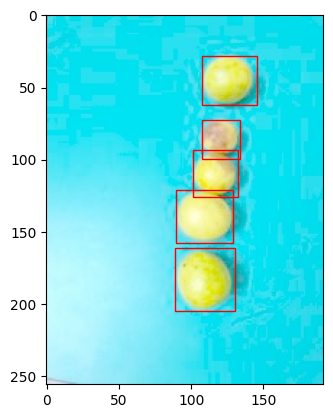

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json

def visualize_annotations(image_path, annotations):
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for annotation in annotations:
        bbox = annotation['bbox']
        x, y, w, h = bbox
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Read JSON data
with open(r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\Augmented_annotations.json", "r") as f:
    data = json.load(f)

image_file_name = "aug_78_5262a68d-IMG20200728191452.jpg"
image_ids = [img["id"] for img in data["images"] if image_file_name in img["file_name"]]

if image_ids:
    desired_image_id = image_ids[0]
    annotations_for_image = [a for a in data['annotations'] if a["image_id"] == desired_image_id]
    
    # Update this to your actual image path
    image_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\images\aug_78_5262a68d-IMG20200728191452.jpg"
    
    visualize_annotations(image_path, annotations_for_image)
else:
    print(f"No annotations found for image {image_file_name}.")


## Transform path in Augmented_annotations.json to be more general like images\\image_name.jpg

The output will be a json file called Annotations.json with the proper paths for each image

In [7]:
# Specify the path to the original JSON file
json_file_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\Augmented_annotations.json"

# Read the original JSON object from the file into a Python dictionary
with open(json_file_path, 'r') as f:
    original_dict = json.load(f)

# Transform the file paths
for image in original_dict['images']:
    file_name = image['file_name']
    new_file_name = "images\\" + os.path.basename(file_name)  # Use os.path.basename to get the file name
    image['file_name'] = new_file_name

# Specify the path to the transformed JSON file
# You can either overwrite the original or save it as a new file
transformed_json_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\Annotations.json"

# Write the modified Python dictionary back to a JSON file
with open(transformed_json_path, 'w') as f:
    json.dump(original_dict, f, indent=4)


## Finally we split the images into 80% train, 10% validation and 10% test dataset containing the according annotations

### !Be careful before running the code below to have a back up of what you have created because the images will be transfered to the train,test,val datasets!

In [10]:
import json
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the parent_directory where the 'Augmented_images' folder is located
parent_directory = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images"

# Define the folder where the augmented images are stored
augmented_directory = os.path.join(parent_directory, r"images")

# Load the annotations file
with open(os.path.join(parent_directory, r"Annotations.json"), "r") as file:
    data = json.load(file)

# Split the images
train_images, interim_images = train_test_split(data['images'], test_size=0.2, random_state=42)
test_images, val_images = train_test_split(interim_images, test_size=0.5, random_state=42)

# Create annotations
train_annotations = [a for a in data['annotations'] if a['image_id'] in [img['id'] for img in train_images]]
test_annotations = [a for a in data['annotations'] if a['image_id'] in [img['id'] for img in test_images]]
val_annotations = [a for a in data['annotations'] if a['image_id'] in [img['id'] for img in val_images]]

# Create directories
for phase in ["train", "test", "val"]:
    main_dir = os.path.join(parent_directory, phase)
    images_dir = os.path.join(main_dir, "images")
    annotations_dir = os.path.join(main_dir, "annotations")
    
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(annotations_dir, exist_ok=True)

# Function to move images and write annotations
def move_and_annotate(images, annotations, phase):
    phase_dir = os.path.join(parent_directory, phase)
    images_dir = os.path.join(phase_dir, "images")
    annotations_dir = os.path.join(phase_dir, "annotations")

    for img in images:
        src_path = os.path.join(augmented_directory, os.path.basename(img['file_name']))
        dst_path = os.path.join(images_dir, os.path.basename(img['file_name']))
        shutil.move(src_path, dst_path)

    with open(os.path.join(annotations_dir, f"{phase}_annotations.json"), "w") as file:
        json.dump({"images": images, "annotations": annotations, "categories": data['categories']}, file,indent=4)


# Move images and write annotations
move_and_annotate(train_images, train_annotations, "train")
move_and_annotate(test_images, test_annotations, "test")
move_and_annotate(val_images, val_annotations, "val")


# Final step is to change the category id's. we noticed that in the Faster R-CNN method of object detection the labeling starts from "1" because "0" is for the background. 

In the label studio when we extract the files in COCO format the category ids (classes) start from "0"

### Train dataset

In [12]:
# Define the path to your existing annotations JSON file
input_file_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\train\annotations\train_annotations.json"

# Define the path to your new annotations JSON file
output_file_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\train\annotations\results.json"

# Read existing COCO-formatted data
with open(input_file_path, 'r') as f:
    coco_data = json.load(f)

# Update category IDs in 'annotations' to start from 1
for annotation in coco_data['annotations']:
    annotation['category_id'] += 1  # Increment category_id by 1

# Update category IDs in 'categories' to start from 1
for category in coco_data['categories']:
    category['id'] += 1  # Increment id by 1

# Save the updated COCO data to the new JSON file
with open(output_file_path, 'w') as f:
    json.dump(coco_data, f, indent=4)


### Val dataset

In [13]:
# Define the path to your existing annotations JSON file
input_file_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\val\annotations\val_annotations.json"

# Define the path to your new annotations JSON file
output_file_path = r"Banana_Lemon_5_fruits_Label_studio\Augmented_images\val\annotations\results.json"

# Read existing COCO-formatted data
with open(input_file_path, 'r') as f:
    coco_data = json.load(f)

# Update category IDs in 'annotations' to start from 1
for annotation in coco_data['annotations']:
    annotation['category_id'] += 1  # Increment category_id by 1

# Update category IDs in 'categories' to start from 1
for category in coco_data['categories']:
    category['id'] += 1  # Increment id by 1

# Save the updated COCO data to the new JSON file
with open(output_file_path, 'w') as f:
    json.dump(coco_data, f, indent=4)


## Now we are ready to use the files train,val,test as we want for our project for this dataset

# Orange_Pomagranate

In [1]:
import cv2
import json
import os
import numpy as np
import shutil

parent_dir = "Orange_Pomagranate_4_fruits_Label_studio"

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = [(i / 255.0) ** invGamma * 255 for i in range(256)]
    table = np.array(table, dtype="uint8")
    return cv2.LUT(image, table)

def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Load the original JSON
with open("Orange_Pomagranate_4_fruits_Label_studio\\result.json", 'r') as f:
    orig_data = json.load(f)

num_original_images = len(orig_data['images'])
target_augmented_images = 10000

# Calculate how many augmentations per image are needed
augmentations_per_image = target_augmented_images // num_original_images

augmented_images = []
augmented_annotations = []

output_image_dir = "Orange_Pomagranate_4_fruits_Label_studio\\Augmented_images\\images"
output_json_dir = "Orange_Pomagranate_4_fruits_Label_studio\\Augmented_images"

if not os.path.exists(output_image_dir):
    os.makedirs(output_image_dir)

image_counter = max([img['id'] for img in orig_data['images']]) + 1  # Start id for new images

for orig_image_data in orig_data['images']:
    image_path = os.path.join(parent_dir, orig_image_data['file_name'])
    img = cv2.imread(image_path)
    
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Step 2: Copy the original image to the output_image_dir
    base_name = os.path.basename(image_path)
    original_file_name = os.path.join(output_image_dir, base_name)
    shutil.copy(image_path, original_file_name)  # Copy the file
    
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")

    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")

    for i in range(augmentations_per_image):
        if i % 2 == 0:
            augmented_img = adjust_gamma(img, i % 4 + 1)  # Adjust gamma
        else:
            augmented_img = gaussian_blur(img)  # Apply Gaussian blur

        # Save the augmented image
        base_name = os.path.basename(image_path)
        new_file_name = os.path.join(output_image_dir, f"aug_{i}_" + base_name)
        cv2.imwrite(new_file_name, augmented_img)

        # Create new image data for augmented image
        new_image_data = {
            'id': image_counter,
            'file_name': new_file_name,
            'height': augmented_img.shape[0],
            'width': augmented_img.shape[1]
        }
        augmented_images.append(new_image_data)
        image_counter += 1

        # Copy annotations for the augmented image
        for annotation in orig_data['annotations']:
            if annotation['image_id'] == orig_image_data['id']:
                new_annotation = annotation.copy()
                new_annotation['image_id'] = new_image_data['id']
                augmented_annotations.append(new_annotation)

# Update the original data with augmented data
orig_data['images'].extend(augmented_images)
orig_data['annotations'].extend(augmented_annotations)

# Save the combined JSON
augmented_json_path = os.path.join(output_json_dir, 'Augmented_annotations.json')  # File path for new JSON
with open(augmented_json_path, 'w') as f:
    json.dump(orig_data, f,indent=4)

# Example of Augmented images:
We are going to plot an image based on the augmented images so that we can check if the augmentation is correct and the bounding boxes are placed correctly.

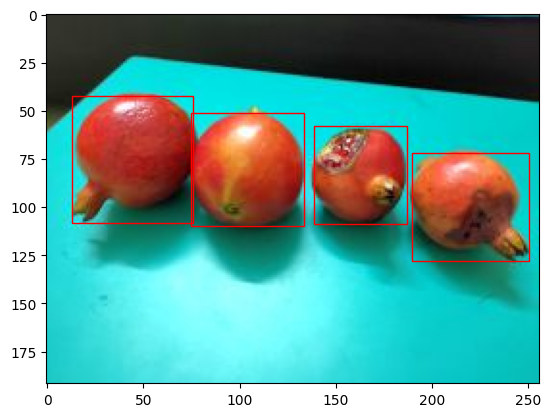

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json

def visualize_annotations(image_path, annotations):
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for annotation in annotations:
        bbox = annotation['bbox']
        x, y, w, h = bbox
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Read JSON data
with open(r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\Augmented_annotations.json", "r") as f:
    data = json.load(f)

image_file_name = "898e8d7a-IMG20200728183142.jpg"
image_ids = [img["id"] for img in data["images"] if image_file_name in img["file_name"]]

if image_ids:
    desired_image_id = image_ids[0]
    annotations_for_image = [a for a in data['annotations'] if a["image_id"] == desired_image_id]
    
    # Update this to your actual image path
    image_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\images\898e8d7a-IMG20200728183142.jpg"
    
    visualize_annotations(image_path, annotations_for_image)
else:
    print(f"No annotations found for image {image_file_name}.")

## Transform path in Augmented_annotations.json to be more general like images\image_name.jpg

The output will be a json file called Annotations.json with the proper paths for each image

In [2]:
# Specify the path to the original JSON file
json_file_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\Augmented_annotations.json"

# Read the original JSON object from the file into a Python dictionary
with open(json_file_path, 'r') as f:
    original_dict = json.load(f)

# Transform the file paths
for image in original_dict['images']:
    file_name = image['file_name']
    new_file_name = "images\\" + os.path.basename(file_name)  # Use os.path.basename to get the file name
    image['file_name'] = new_file_name

# Specify the path to the transformed JSON file
# You can either overwrite the original or save it as a new file
transformed_json_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\Annotations.json"

# Write the modified Python dictionary back to a JSON file
with open(transformed_json_path, 'w') as f:
    json.dump(original_dict, f, indent=4)


## Finally we split the images into 80% train, 10% validation and 10% test dataset containing the according annotations

## !Be careful before running the code below to have a back up of what you have created because the images will be transfered to the train,test,val datasets!¶

In [3]:
import json
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the parent_directory where the 'Augmented_images' folder is located
parent_directory = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images"

# Define the folder where the augmented images are stored
augmented_directory = os.path.join(parent_directory, r"images")

# Load the annotations file
with open(os.path.join(parent_directory, r"Annotations.json"), "r") as file:
    data = json.load(file)

# Split the images
train_images, interim_images = train_test_split(data['images'], test_size=0.2, random_state=42)
test_images, val_images = train_test_split(interim_images, test_size=0.5, random_state=42)

# Create annotations
train_annotations = [a for a in data['annotations'] if a['image_id'] in [img['id'] for img in train_images]]
test_annotations = [a for a in data['annotations'] if a['image_id'] in [img['id'] for img in test_images]]
val_annotations = [a for a in data['annotations'] if a['image_id'] in [img['id'] for img in val_images]]

# Create directories
for phase in ["train", "test", "val"]:
    main_dir = os.path.join(parent_directory, phase)
    images_dir = os.path.join(main_dir, "images")
    annotations_dir = os.path.join(main_dir, "annotations")
    
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(annotations_dir, exist_ok=True)

# Function to move images and write annotations
def move_and_annotate(images, annotations, phase):
    phase_dir = os.path.join(parent_directory, phase)
    images_dir = os.path.join(phase_dir, "images")
    annotations_dir = os.path.join(phase_dir, "annotations")

    for img in images:
        src_path = os.path.join(augmented_directory, os.path.basename(img['file_name']))
        dst_path = os.path.join(images_dir, os.path.basename(img['file_name']))
        shutil.move(src_path, dst_path)

    with open(os.path.join(annotations_dir, f"{phase}_annotations.json"), "w") as file:
        json.dump({"images": images, "annotations": annotations, "categories": data['categories']}, file,indent=4)


# Move images and write annotations
move_and_annotate(train_images, train_annotations, "train")
move_and_annotate(test_images, test_annotations, "test")
move_and_annotate(val_images, val_annotations, "val")


## Final step is to change the category id's. we noticed that in the Faster R-CNN method of object detection the labeling starts from "1" because "0" is for the background.

In the label studio when we extract the files in COCO format the category ids (classes) start from "0"

### Train dataset

In [4]:
# Define the path to your existing annotations JSON file
input_file_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\train\annotations\train_annotations.json"

# Define the path to your new annotations JSON file
output_file_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\train\annotations\results.json"

# Read existing COCO-formatted data
with open(input_file_path, 'r') as f:
    coco_data = json.load(f)

# Update category IDs in 'annotations' to start from 1
for annotation in coco_data['annotations']:
    annotation['category_id'] += 1  # Increment category_id by 1

# Update category IDs in 'categories' to start from 1
for category in coco_data['categories']:
    category['id'] += 1  # Increment id by 1

# Save the updated COCO data to the new JSON file
with open(output_file_path, 'w') as f:
    json.dump(coco_data, f, indent=4)


### Val dataset

In [5]:
# Define the path to your existing annotations JSON file
input_file_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\val\annotations\val_annotations.json"

# Define the path to your new annotations JSON file
output_file_path = r"Orange_Pomagranate_4_fruits_Label_studio\Augmented_images\val\annotations\results.json"

# Read existing COCO-formatted data
with open(input_file_path, 'r') as f:
    coco_data = json.load(f)

# Update category IDs in 'annotations' to start from 1
for annotation in coco_data['annotations']:
    annotation['category_id'] += 1  # Increment category_id by 1

# Update category IDs in 'categories' to start from 1
for category in coco_data['categories']:
    category['id'] += 1  # Increment id by 1

# Save the updated COCO data to the new JSON file
with open(output_file_path, 'w') as f:
    json.dump(coco_data, f, indent=4)


### Now we are ready to use the files train,val,test as we want for our project for this dataset too